In [1]:
import sys
(sys.path).insert(1,'/Users/pedroguicardi/Desktop/CMB_Analysis/MAPSIMS/directories')

import mapsims
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
import healpy as hp
import matplotlib
from matplotlib import pyplot as plt
from pixell import enmap, enplot, reproject, utils, curvedsky
from ad_fns import *
from astropy.io import fits
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from ccat_models import ccat_noise as CCAT_noise
import scipy.optimize as op

passed


In [ ]:
NSIDE = 512
lat_lmax = 1500
sim_num = 20
output_file = "sims_output_test_1"
pysm_string = "d0,s0"


noise = mapsims.SONoiseSimulator(
        nside=NSIDE,
        return_uK_CMB = True,
        sensitivity_mode = "baseline",
        apply_beam_correction = False,
        apply_kludge_correction = False,
        homogeneous=False,
        rolloff_ell = 50,
        ell_max = lat_lmax,
        survey_efficiency = 1.0,
        full_covariance = False,
        LA_years = 5,
        LA_noise_model = "CcatLatv2b",
        elevation = 50,
        SA_years = 5,
        SA_one_over_f_mode = "pessimistic"
    )

def read_sims(sim_num, noise, NSIDE, output_file, pysm_string, apodize=False):
    "output shape will be of the form (bands_#, sim_num , 3, n_pix)"
    chs = ["LC1","LC1","LC2","LC2","LC3"]
    bands = [noise.tubes['LC1'][0].tag, noise.tubes['LC1'][1].tag,noise.tubes['LC2'][0].tag, noise.tubes['LC2'][1].tag,noise.tubes['LC3'][0].tag]
    output = np.zeros((5,sim_num, 3, 12*(NSIDE)**2))
    for j in np.arange(sim_num):
        for k in np.arange(5):
            tmp = hp.fitsfunc.read_map(output_file +"/"+bands[k]+"_" + chs[k]+"_NSIDE_" + str(NSIDE) + "_TAG_" + pysm_string + "_" + str(j) + "_" +".fits", field=(0,1,2))
            if apodize:
                for h in np.arange(tmp.shape[0]):
                    tmp[h,:] = apodize_map(tmp[h,:])
                    
            output[k,j,:,:] = tmp
    return output
    
    
    
sim_data = read_sims(20,noise, NSIDE, output_file, pysm_string, apodize = True)
print(sim_data.shape)


Compute Power Spectra:

In [6]:
pow_specs = np.zeros((sim_data.shape[0], sim_data.shape[1], 6, lat_lmax+1))
for i in np.arange(sim_data.shape[0]):
    for j in np.arange(sim_data.shape[1]):
        pow_specs[i,j,:,:] = hp.sphtfunc.anafast(sim_data[i,j,:,:], lmax = lat_lmax)
        
avg_spec = np.mean(pow_specs, axis=1)
std_spec = np.std(pow_specs,axis=1)
print(avg_spec.shape, std_spec.shape)

(5, 6, 1501) (5, 6, 1501)


In [15]:
import fgspectra.fgspectra.cross as fgc

Plot averaged Temperature spectra:

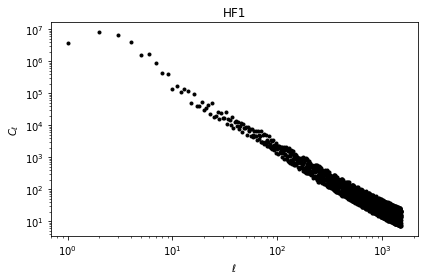

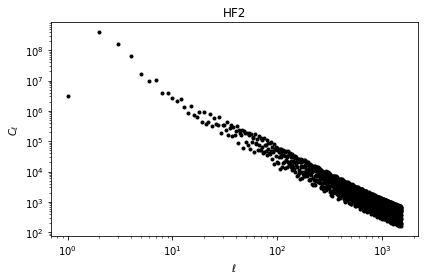

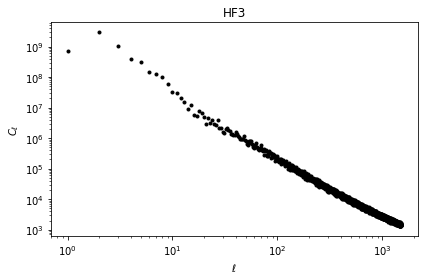

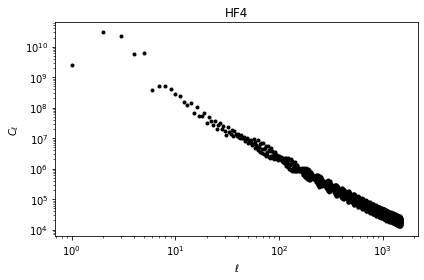

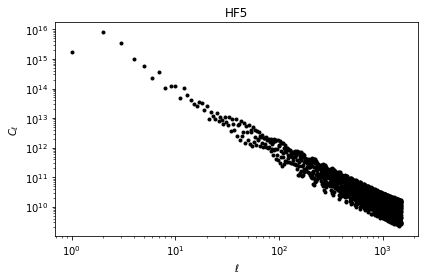

<Figure size 432x288 with 0 Axes>

In [21]:
chs = ["HF1","HF2","HF3","HF4","HF5"]
ell = np.arange(avg_spec.shape[-1])
for i in np.arange(5):
    plt.errorbar(ell, avg_spec[i,0], yerr=std_spec[i,0], fmt=".k", capsize=0)
    plt.title(chs[i])
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'$C_{\ell}$')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
    plt.clf()

Why is the error bars so small? The std should be large?

In [23]:
print(std_spec)

[[[4.65661287e-10 0.00000000e+00 0.00000000e+00 ... 8.88178420e-16
   7.10542736e-15 1.77635684e-15]
  [0.00000000e+00 0.00000000e+00 2.84217094e-14 ... 2.71050543e-20
   1.35525272e-20 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.71050543e-20
   2.71050543e-20 2.71050543e-20]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.08420217e-19
   0.00000000e+00 4.33680869e-19]
  [0.00000000e+00 0.00000000e+00 3.55271368e-15 ... 4.23516474e-22
   2.11758237e-22 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.08420217e-19
   1.08420217e-19 2.16840434e-19]]

 [[0.00000000e+00 9.31322575e-10 0.00000000e+00 ... 1.13686838e-13
   0.00000000e+00 1.70530257e-13]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   1.08420217e-19 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 1.13686838e-13 ... 5.42101086e-20
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.38777878e-17
   0.00000000e+00 8.67

Just testing out fgspectra

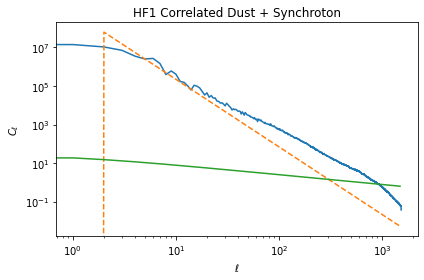

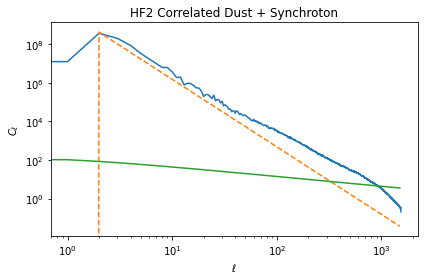

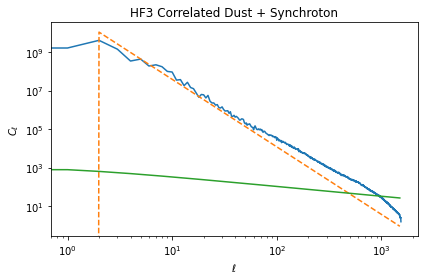

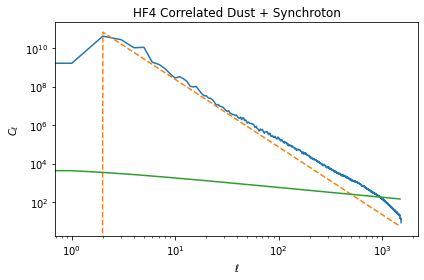

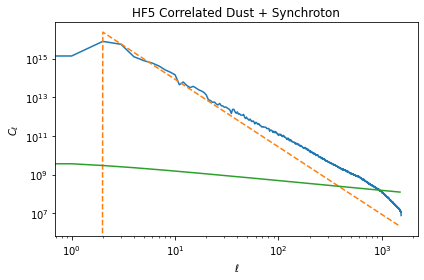

<Figure size 432x288 with 0 Axes>

In [28]:
nu = np.array([222.0, 280.0, 348.0, 405.0, 850.0])

dust_params = dict(nu=nu, beta=1.54, temp=19.6, nu_0=353.)
sync_params = dict(nu=nu, beta=-3.15, nu_0=23.)
frequency_params = dict(kwseq=(dust_params, sync_params))

power_params = dict(
    ell=np.arange(1500)[1:],
    alpha=np.array([-2.51, -3.]) + 2,  # +2 to (almost) get D_ell
    ell_0=84,
    amp=np.array([137.0, 0.6]),
    rho=0.17
)

dust_sync = fgc.CorrelatedDustSynchrotron()

cl = dust_sync(frequency_params, power_params)

pspec_list = []
for ch in ["LC1", "LC2", "LC3"]:
    ell_sim, ps_T, ps_P, fsky, wnoise_power, weightsMap = noise.get_noise_properties(ch)
    pspec_list.append(ps_T[:-1])
pspec_list = np.array(pspec_list)
pspec_list = np.array([pspec_list[0,0],pspec_list[0,1],pspec_list[1,0],pspec_list[1,1],pspec_list[2,0]])
    
for i in np.arange(cl.shape[0]):
    apodized_map,w = apodize_map(sim_data[i,0,0], n_itp=5)
    
    plt.plot(hp.sphtfunc.anafast(apodized_map)/w )
    plt.plot(pspec_list[i], label='Theoretical ',linestyle='--')
    plt.plot(cl[i,i])
    plt.title(chs[i] + " Correlated Dust + Synchroton")
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'$C_{\ell}$')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
    plt.clf()


Model center parameters need tuning? 